# R estimation from Denmark, Ontario, Britain, and Switzerland

## Methodology

Each dataset contains the following:
* Omicron variant case for a region, from testing
* Non-omicron variant case for a region, from testing
* Total cases for a region

We assume that the portion of Omicron variant in the tested sample is the same as the Omicron variant in the region.

With that assumption, the number of Omicron cases in a region is imputed.

The generation time of the Omicron variant is assumed to be the same as other variants. We use the value from [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7201952/), which gives a generation time of 5.2 days.

The last ten days of imputed number of Omicron cases in a region is used to fit an exponential function of the form $y = ae^{bx}$

$ R_t $ is calcuated as $ R_t = e^{5.2b} $

$ R_0 $ calculations are also provided. The only difference from $ R_t $ is that those use the values from the _first_ ten days with data.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText
import numpy as np

In [2]:
GEN_TIME = 5.2
RT_WINDOW = 10
R0_WINDOW = 10

In [3]:
owid = pd.read_csv('./data/owid_global/owid-covid-data.csv')
owid['date'] = pd.to_datetime(owid['date'])

In [4]:
# Fit the function y = A * exp(B * x) to the data
# returns (A, B)
# From: https://mathworld.wolfram.com/LeastSquaresFittingExponential.html
def fit_exp(xs, ys):
    S_x2_y = 0.0
    S_y_lny = 0.0
    S_x_y = 0.0
    S_x_y_lny = 0.0
    S_y = 0.0
    for (x,y) in zip(xs, ys):
        S_x2_y += x * x * y
        S_y_lny += y * np.log(y)
        S_x_y += x * y
        S_x_y_lny += x * y * np.log(y)
        S_y += y
    #end
    a = (S_x2_y * S_y_lny - S_x_y * S_x_y_lny) / (S_y * S_x2_y - S_x_y * S_x_y)
    b = (S_y * S_x_y_lny - S_x_y * S_y_lny) / (S_y * S_x2_y - S_x_y * S_x_y)
    return (np.exp(a), b)

In [5]:
def exp_func(x, a, b):
    return a*np.exp(b*x)

In [6]:
def get_r_from_fit(a,b):
    t0 = exp_func(0, a, b)
    t1 = exp_func(GEN_TIME, a, b)
    return t1/t0

In [7]:
def impute_and_fit(df):
    imputed = df['new_cases'] * (df['sgtf_count']/(df['non_sgtf_count'] + df['sgtf_count']))
    fit_df = df.copy()
    fit_df['imputed_omicron'] = imputed
    fit_df.sort_values('date')
    fit_df = fit_df[fit_df['imputed_omicron'] > 0]

    first_date = fit_df.iloc[-RT_WINDOW]['date']
    last_date = fit_df.iloc[R0_WINDOW]['date']
    zero_date = fit_df.iloc[0]['date']
        
    days = (df['date'] - first_date).dt.days
    
    rt_mask = df['date'] > first_date
    r0_mask = np.logical_and(df['date'] < first_date, df['date'] >= zero_date)
    
    fit_df['days'] = (fit_df['date'] - first_date).dt.days
    
    at, bt = fit_exp(fit_df.loc[rt_mask, 'days'], fit_df.loc[rt_mask, 'imputed_omicron'])
    a0, b0 = fit_exp(fit_df.loc[r0_mask, 'days'], fit_df.loc[r0_mask, 'imputed_omicron'])

    fitted_t = exp_func(days, at, bt)
    fitted_0 = exp_func(days, a0, b0)
    
    implied_rt = get_r_from_fit(at, bt)
    implied_r0 = get_r_from_fit(a0, b0)
    
    joins = pd.DataFrame({
        'imputed_omicron': imputed,
        'days': days,
        'fitted_0': fitted_0,
        'fitted_t': fitted_t,
        'date': df['date'],
        'rt_mask': rt_mask,
        'r0_mask': r0_mask,
    })
    return joins, implied_rt, implied_r0, 
    

In [8]:
def show_omicron(df, implied_rt, implied_r0, region_name):
    fig, axes = plt.subplots(figsize = (20,10)) 
    plt.yscale('log', base=2)
    axes.plot(df['date'], df['new_cases'], label="Daily New Cases")
    axes.plot(df['date'], df['imputed_omicron'], label="Imputed Omicron Cases")
    axes.plot(df[df['r0_mask']]['date'], df[df['r0_mask']]['fitted_0'], label="Fitted Omicron Cases From Beginning")
    axes.plot(df[df['rt_mask']]['date'], df[df['rt_mask']]['fitted_t'], label="Fitted Omicron Cases From Most Recent")
    anchored_text = AnchoredText("Implied R0 {:.2f} \nImplied RT {:.2f}".format(implied_r0, implied_rt), loc=3, prop=dict(size=15))
    axes.legend(loc=2)
    axes.add_artist(anchored_text)
    axes.set_title("{} Omicron Progression".format(region_name))
    axes.plot()

In [9]:
denmark_owid = owid[owid['iso_code'] == 'DNK']

## Denmark

Let's look at Denmark first, with data retreived from the [Statens Serum Institut](https://covid19.ssi.dk/virusvarianter/delta-pcr)



In [10]:
denmark_csv = pd.read_csv('./data/denmark/denmark_numbers.csv', delimiter=" ", decimal=",")

In [11]:
denmark_csv['date'] = pd.to_datetime(denmark_csv['date'])

denmark_df = pd.merge(denmark_owid[['date', 'new_cases']], denmark_csv, how="inner")
denmark_df['sgtf_count'] = denmark_df['omicron_pcr']
denmark_df['non_sgtf_count'] = denmark_df['positive_pcr'] - denmark_df['omicron_pcr']

In [12]:
joins, implied_rt, implied_r0 = impute_and_fit(denmark_df)
denmark_df = denmark_df.merge(joins)

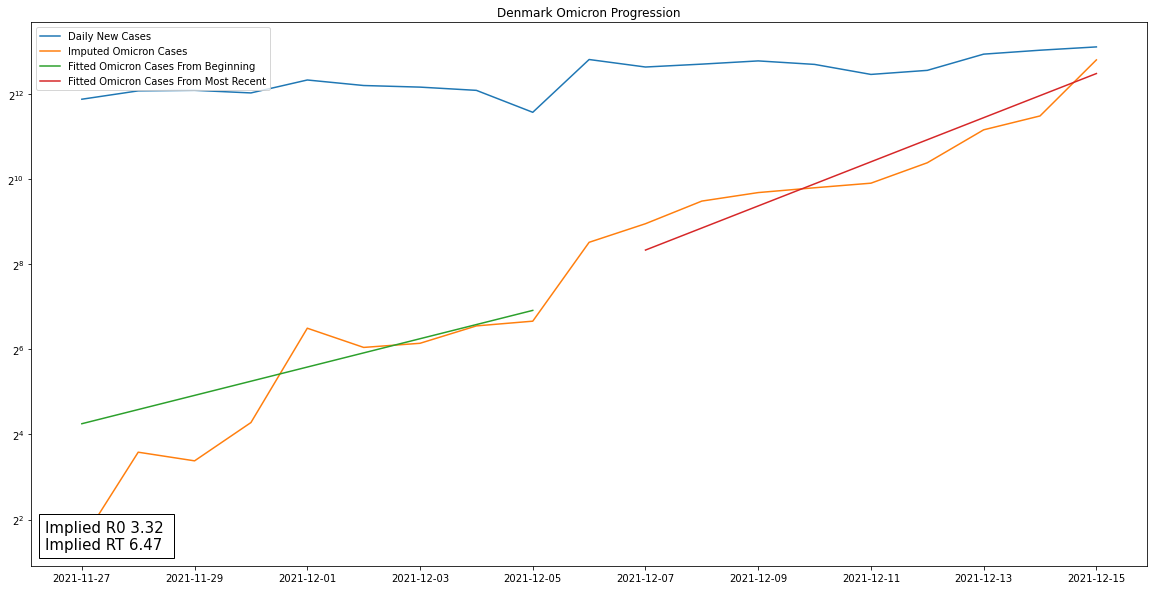

In [13]:
show_omicron(denmark_df, implied_rt, implied_r0, "Denmark")

## Ontario

[Public Health Ontario's Report](https://www.publichealthontario.ca/-/media/documents/ncov/epi/covid-19-early-dynamics-omicron-ontario-epi-summary.pdf?sc_lang=en) does not provide direct numbers but does provide a chart from which data can be extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) 

S Gene Targeting Failure is used as a proxy for Omicron variant testing, since Delta, the other prevelant variant of concern, has its S gene targeted successfully.

In [14]:
ontario_sgtf_csv = pd.read_csv('./data/ontario/sgtf_ontario.csv', header=None).rename(mapper={0: 'date', 1: 'sgtf_count'}, axis=1)
ontario_non_sgtf_csv = pd.read_csv('./data/ontario/non-SGTF_ontario.csv', header=None).rename(mapper={0: 'date', 1: 'non_sgtf_count'}, axis=1)

In [15]:
ontario_csv = pd.merge(ontario_sgtf_csv, ontario_non_sgtf_csv, how="outer", on=None)
ontario_csv['date'] = pd.to_datetime(ontario_csv['date'])

In [16]:
ontario_base = pd.read_csv('./data/ontario/covidtesting.csv')
ontario_base['date'] = pd.to_datetime(ontario_base['Reported Date'])
ontario_base['new_cases'] = ontario_base['Confirmed Positive']

In [17]:
ontario_df = pd.merge(ontario_csv, ontario_base[['date', 'new_cases']], how='inner')
ontario_df.sort_values('date', inplace=True)

# hard remove one data point from 2021-11-08

ontario_df.loc[ontario_df['date'] == pd.to_datetime('2021-11-08'),'sgtf_count'] = 0

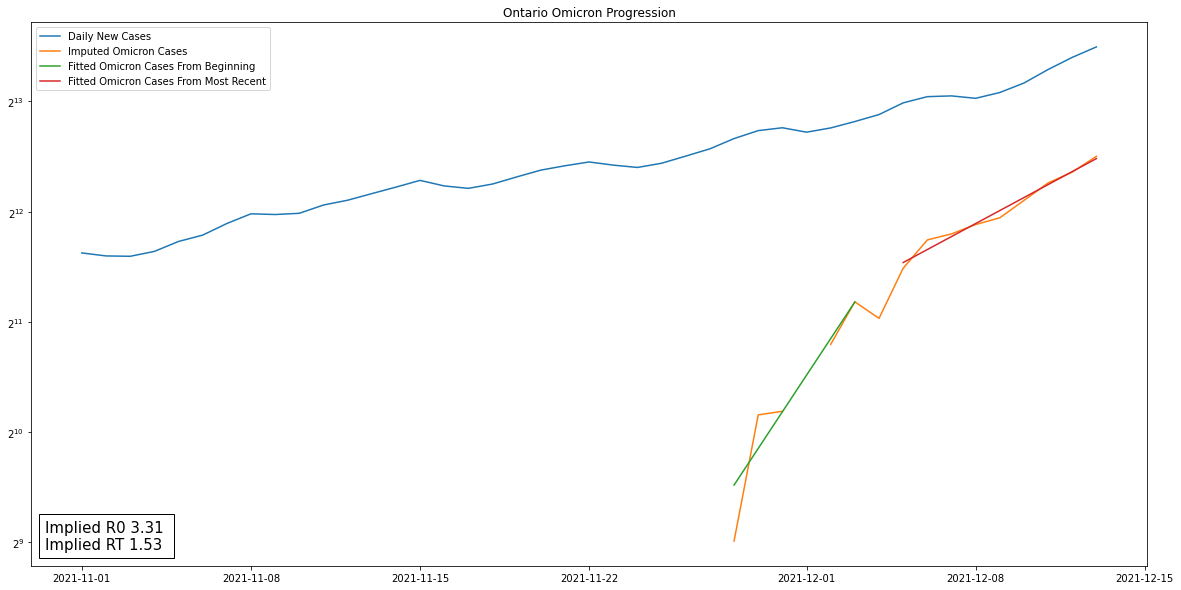

In [18]:
joins, implied_rt, implied_r0 = impute_and_fit(ontario_df)
ontario_df = ontario_df.merge(joins)
show_omicron(ontario_df, implied_rt, implied_r0, "Ontario")

## Britain

Britain has suffered heavily from Omicron as well. Data sourced from [Theo Anderson's Github](https://gist.github.com/theosanderson/1a37c2bb7ecc541ec93501556a0bc545), and can be downloaded from [UK Coronavirus Dashboard](https://coronavirus.data.gov.uk/details/download)


In [19]:
britain_base = pd.read_csv('./data/britain/region_2021-12-17.csv')
britain_strain = pd.read_csv('./data/britain/sgtf_regionepicurve_2021-12-16-2.csv')

In [20]:
britain_strain['sgtf_count'] = britain_strain.apply(lambda x: 0 if x['sgtf'] != 'Cases with confirmed SGTF' else x['n'], axis=1)
britain_strain['non_sgtf_count'] = britain_strain.apply(lambda x: 0 if x['sgtf'] == 'Cases with confirmed SGTF' else x['n'], axis=1)

In [21]:
britain_base['date'] = pd.to_datetime(britain_base['date'])
britain_base['new_cases'] = britain_base['newCasesBySpecimenDate']

britain_strain['date'] = pd.to_datetime(britain_strain['specimen_date'])
britain_strain['areaName'] = britain_strain['PHEC_name']

britain_base_agg = britain_base.groupby(['date', 'areaName']).aggregate({'new_cases': 'sum'}).reset_index()

britain_strain_agg = britain_strain.groupby(['date', 'areaName']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum'}).reset_index()

britain_df = britain_base_agg.merge(britain_strain_agg)

britain_agg_df = britain_df.groupby(['date']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum', 'new_cases': 'sum'}).reset_index()

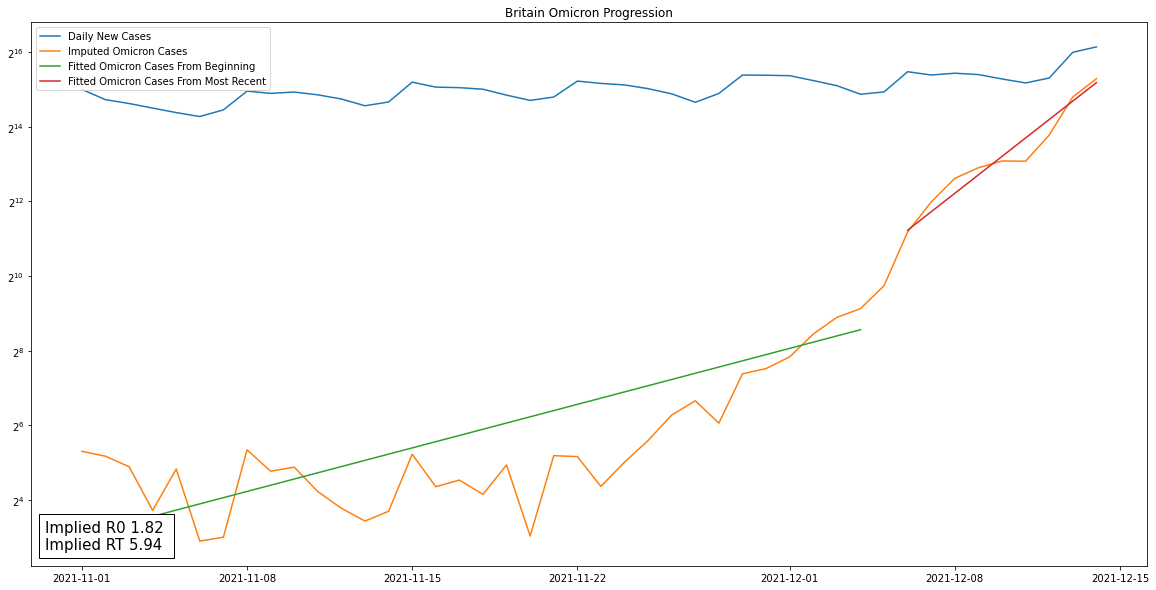

In [22]:
joins, implied_rt, implied_r0 = impute_and_fit(britain_agg_df)
britain_agg_df = britain_agg_df.merge(joins)
show_omicron(britain_agg_df, implied_rt, implied_r0, "Britain")

## Switzerland

Switzerland's [Federal Office of Public Health](https://www.covid19.admin.ch/en/epidemiologic/virus-variants) has a full set of data available.

The Omicron strain is labelled B.1.1.529

In [23]:
swiss_base = pd.read_csv('./data/switzerland/data/COVID19Cases_geoRegion.csv')
swiss_strain = pd.read_csv('./data/switzerland/data/COVID19Variants_wgs.csv')

In [24]:
swiss_strain['sgtf_count'] = swiss_strain.apply(lambda x: x['entries'] if x['variant_type'] == 'B.1.1.529' else 0, axis=1)
swiss_strain['non_sgtf_count'] = swiss_strain.apply(lambda x: 0 if x['variant_type'] == 'B.1.1.529' else x['entries'], axis=1)
swiss_strain['date'] = pd.to_datetime(swiss_strain['date'])
swiss_strain_agg = swiss_strain.groupby(['date', 'geoRegion']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum'}).reset_index()

In [25]:
swiss_base['date'] = pd.to_datetime(swiss_base['datum'])
swiss_base['new_cases'] = swiss_base['entries']

swiss_base_agg = swiss_base.groupby(['date', 'geoRegion']).aggregate({'new_cases': 'sum'}).reset_index()

swiss_df = pd.merge(swiss_base_agg, swiss_strain_agg, how='inner')

swiss_agg_df = swiss_df.groupby(['date']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum', 'new_cases': 'sum'}).reset_index()

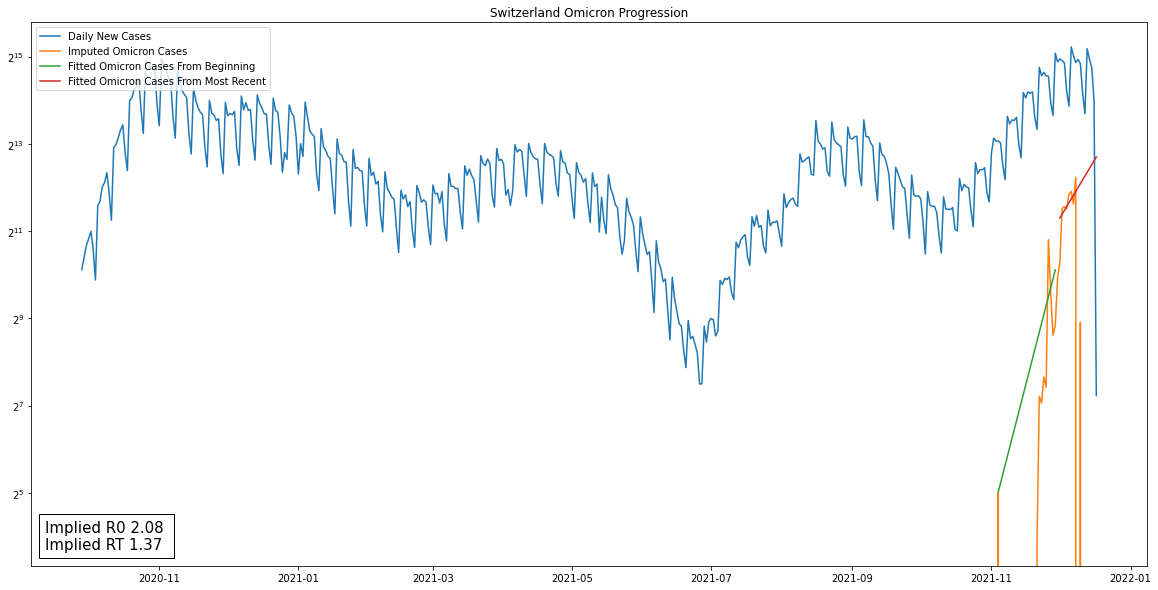

In [26]:
joins, implied_rt, implied_r0 = impute_and_fit(swiss_agg_df)
swiss_agg_df = swiss_agg_df.merge(joins)
show_omicron(swiss_agg_df, implied_rt, implied_r0, "Switzerland")